# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import re

import scipy.stats as stats

from scipy import stats as st

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.compose import make_column_transformer

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.neighbors import KNeighborsRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [3]:
try:
    df = pd.read_csv('/Users/admin/Downloads/autos.csv')
    
except:
    df = pd.read_csv('https://code.s3.yandex.net//datasets/autos.csv')   

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


1. Данные представленные 15 столбцами, 354369 значений, столбцы типа int и object
1. В значениях есть выбросы

In [7]:
new_columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]
df.columns = new_columns

1. Приведем названия столбцов к snake_case

In [8]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Процент пропущенных значений в столбце' + "\n", fontsize = 22)    
        );    
    except:
        print('пропусков не осталось или произошла ошибка в первой части функции ')

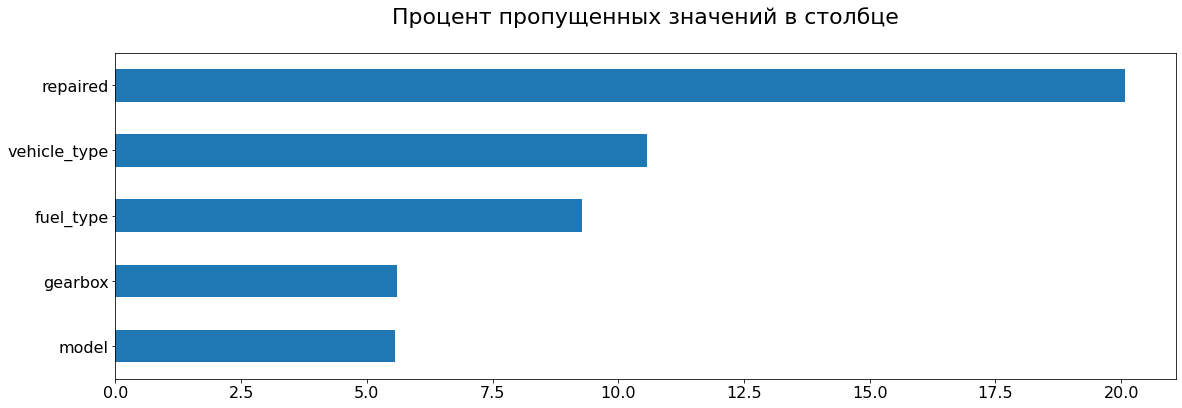

In [9]:
pass_value_barh(df)

1. Пропуски имеются в 5 столбцах, больше всего около 20% в столбце repaired - был ли ремонт авто

[Text(0, 0, 'date_crawled'),
 Text(1, 0, 'price'),
 Text(2, 0, 'vehicle_type'),
 Text(3, 0, 'registration_year'),
 Text(4, 0, 'gearbox'),
 Text(5, 0, 'power'),
 Text(6, 0, 'model'),
 Text(7, 0, 'kilometer'),
 Text(8, 0, 'registration_month'),
 Text(9, 0, 'fuel_type'),
 Text(10, 0, 'brand'),
 Text(11, 0, 'repaired'),
 Text(12, 0, 'date_created'),
 Text(13, 0, 'number_of_pictures'),
 Text(14, 0, 'postal_code'),
 Text(15, 0, 'last_seen')]

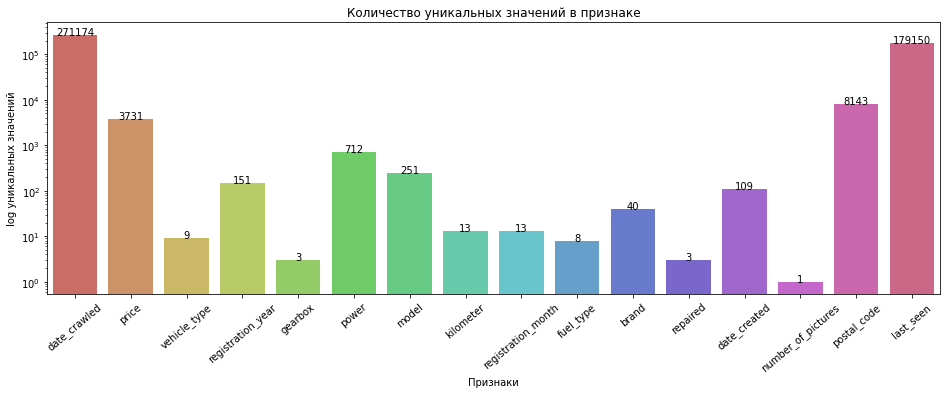

In [10]:
plt.figure(figsize=(16,5))

columns = df.columns
uniqs = [len(df[column].unique()) for column in columns]

ax = sns.barplot(x=columns, y=uniqs, palette='hls', log=True)
ax.set(xlabel='Признаки', ylabel='log уникальных значений', title='Количество уникальных значений в признаке' )

for p, uniq in zip(ax.patches, uniqs):
    ax.text(p.get_x() + p.get_width()/2,
           uniq,
           uniq,
           ha='center')

ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

1. Количество уникальных значений в каждом столбце

Text(0.5, 1.0, 'Гистограмма распределения цены')

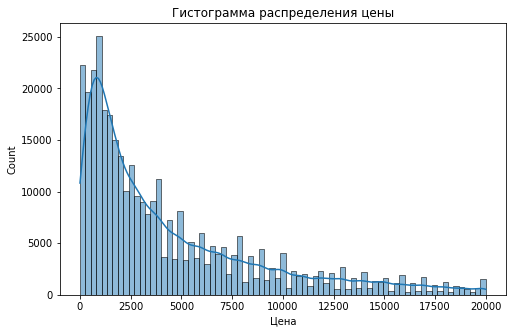

In [11]:
plt.figure(figsize=(8,5))

ax = sns.histplot(df['price'].values, bins=75, kde=True)
ax.set_xlabel('Цена')
ax.set_title('Гистограмма распределения цены')

1. Цены начинаются от 0 значения и ограничены 20000, наибольшее число объявлений от 0 до 2000, далее число объявлений убывает с ростом цены

In [12]:
df['brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

In [13]:
date_count = df['brand'].value_counts().head(10)

Text(0.5, 1.0, 'Колчиество объявлений по маркам')

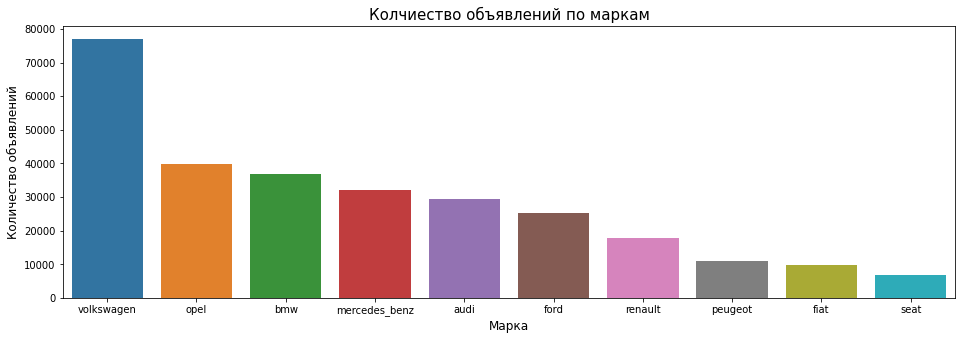

In [14]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Марка', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по маркам', fontsize=15)

1. Основнаы марка среди объявлений - volkswagen, около 80000 объявлений 

In [15]:
date_count = df.groupby(['brand','model']).count()['price'].reset_index().sort_values(by='price' ,ascending=False).reset_index(drop=True)

date_count.rename(columns = {'price':'count'}, inplace = True)

date_count['brand_model'] = date_count['brand'] + " " + date_count['model']
date_count = date_count.drop(['brand', 'model'], axis=1)

date_count.head(10)

,count,brand_model
0,29232,volkswagen golf
1,19761,bmw 3er
2,13066,volkswagen polo
3,12570,opel corsa
4,10809,opel astra
5,10146,volkswagen passat
6,9900,audi a4
7,8312,mercedes_benz c_klasse
8,7868,bmw 5er
9,6785,mercedes_benz e_klasse


[Text(0, 0, 'volkswagen golf'),
 Text(1, 0, 'bmw 3er'),
 Text(2, 0, 'volkswagen polo'),
 Text(3, 0, 'opel corsa'),
 Text(4, 0, 'opel astra'),
 Text(5, 0, 'volkswagen passat'),
 Text(6, 0, 'audi a4'),
 Text(7, 0, 'mercedes_benz c_klasse'),
 Text(8, 0, 'bmw 5er'),
 Text(9, 0, 'mercedes_benz e_klasse')]

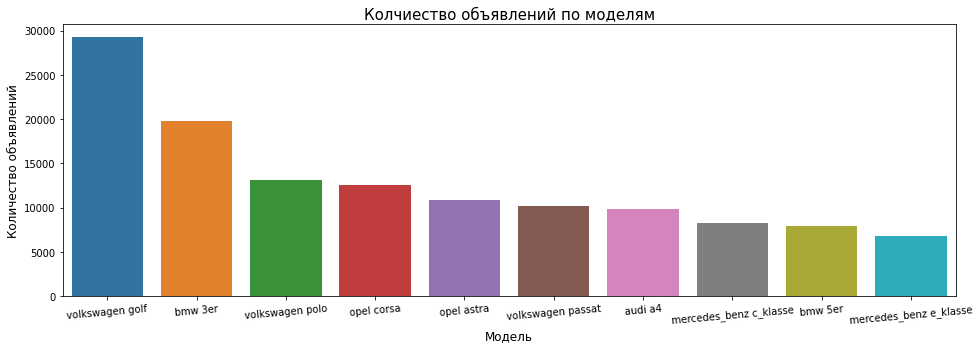

In [16]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count['brand_model'].head(10), y=date_count['count'].head(10).values)
ax.set_xlabel('Модель', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по моделям', fontsize=15)

ax.set_xticklabels(ax.get_xticklabels(), rotation=5)

1. Самая популярная модель - volkswagen golf, почти 30000 объявлений
1. Первые 10 самых популярных моделей принадлежат первым 5 самым популярным маркам

In [17]:
date_count = df['fuel_type'].value_counts()
date_count

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

petrol и gasoline - два названия для бензина, lpg и cng - типы газомоторного топлива для которых требуются различное оборудование

Text(0.5, 1.0, 'Колчиество объявлений по типу топлива')

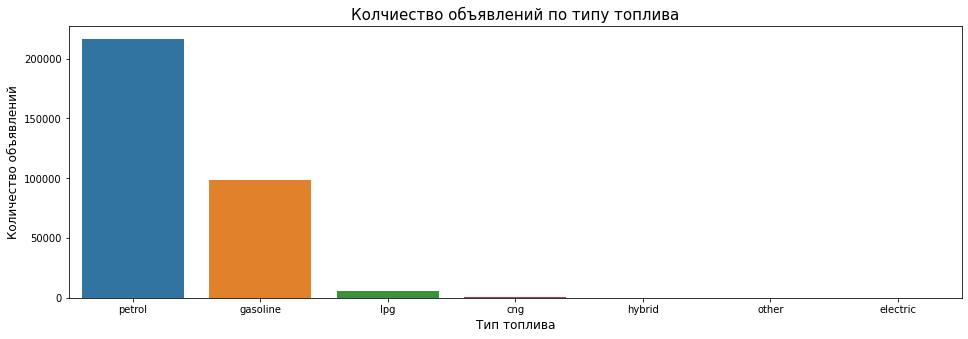

In [18]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Тип топлива', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по типу топлива', fontsize=15)

1. Почти все авто в представденном датасете объявлений имеют один из двух типов топлива petrol и gasoline   
1. petrol и gasoline - два названия для бензина, так что почти все авто имеют один тип топлива
1. lpg и cng - типы газомоторного топлива для которых требуются различное оборудование

In [19]:
date_count = df['gearbox'].value_counts()
date_count

manual    268251
auto       66285
Name: gearbox, dtype: int64

Text(0.5, 0, 'Тип коробки передач')

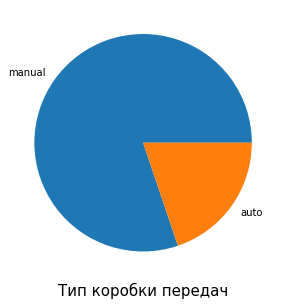

In [20]:
fiq, ax = plt.subplots(figsize=(10,5))

ax.pie(date_count.values, labels=date_count.index)

ax.set_xlabel('Тип коробки передач', fontsize=15)

1. Больше 3/4 машин с коробкой передач типа manual 

In [21]:
date_count = df['vehicle_type'].value_counts()
date_count

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Text(0.5, 0, 'Тип транспортного средства')

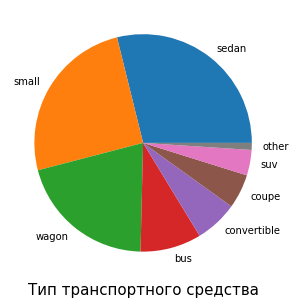

In [22]:
fiq, ax = plt.subplots(figsize=(10,5))

ax.pie(date_count.values, labels=date_count.index)

ax.set_xlabel('Тип транспортного средства', fontsize=15)

1. Типы авто в датасете представленные примерно в равных долях для 3 основных типов авто и группы из 5 отстальных
1. Три основных типа авто: sedan, small, wagon

In [23]:
date_count = df['kilometer'].value_counts().sort_index()
date_count

5000        6397
10000       1222
20000       3975
30000       4436
40000       4911
50000       6232
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36454
150000    238209
Name: kilometer, dtype: int64

Text(0.5, 1.0, 'Колчиество объявлений по километражу пробега')

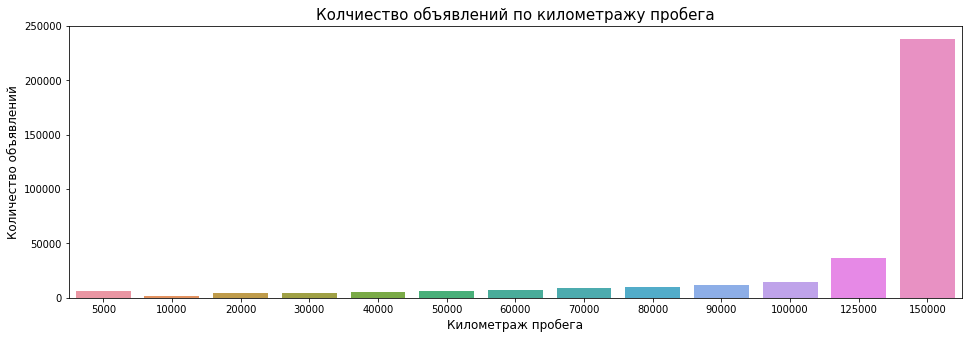

In [24]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Километраж пробега', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по километражу пробега', fontsize=15)

1. Подавляющее большинство представленных авто имее пробег 150000 км

In [25]:
date_count = df['repaired'].value_counts(normalize=True)
date_count

no     0.872697
yes    0.127303
Name: repaired, dtype: float64

Text(0.5, 0, 'Была машина в ремонте')

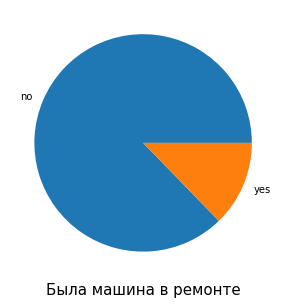

In [26]:
fiq, ax = plt.subplots(figsize=(10,5))

ax.pie(date_count.values, labels=date_count.index)

ax.set_xlabel('Была машина в ремонте', fontsize=15)

Странный показатель - большинство машин с пробегом больш 150000 и не были в ремонте

1. 87 % машин из объявлений не были в ремонте
1. Странный показатель - большинство машин с пробегом 150000 и не были в ремонте

In [27]:
df['registration_year'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [28]:
df['date_created'].max()

'2016-04-07 00:00:00'

Верхняя граница годов регистрации авто 2016 нижня 1961

In [29]:
(df.loc[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1961), 'registration_year'].shape[0] 
 / df.shape[0])

0.9572761725771723

Выбранные данные отражают более 95% объектов, остальные значения неверны

Text(0.5, 1.0, 'Гистограмма годов регистрации')

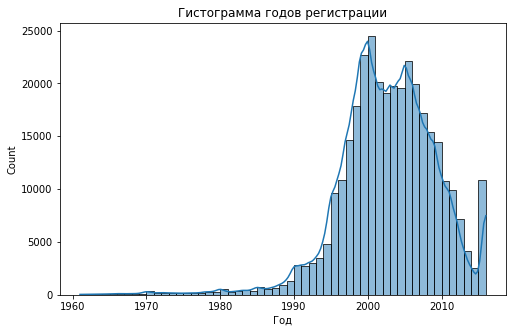

In [30]:
plt.figure(figsize=(8,5))

ax = sns.histplot(df.loc[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1961), 'registration_year'],
                  bins=55,kde=True)
ax.set_xlabel('Год')
ax.set_title('Гистограмма годов регистрации')

1. В данных о годах присутствуют ошибочные значения, вызванные возможно неправильным вводом данных
1. В основном машины представленные в датасете имеют год регистрации между 1995 и 2013, а так же много объявлений о машинах зарегестрированных в 2016 году - что для данного датасета год когдаданные были собраны

In [31]:
date_count = df['registration_month'].value_counts()

Text(0.5, 1.0, 'Колчиество объявлений по месяцам регистрации авто')

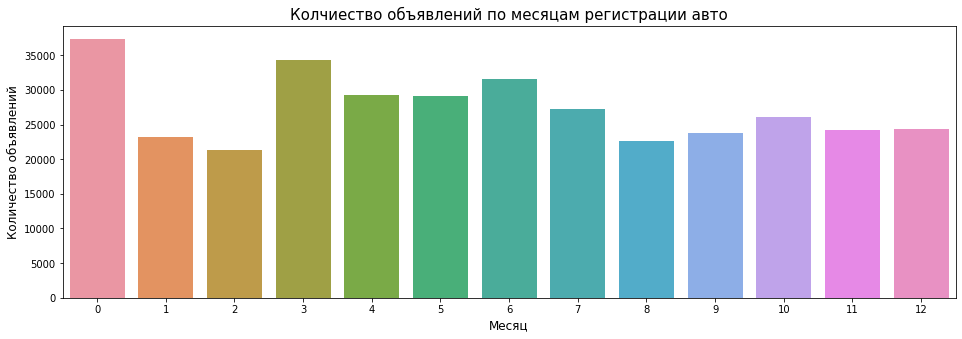

In [32]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=date_count.index, y=date_count.values)
ax.set_xlabel('Месяц', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по месяцам регистрации авто', fontsize=15)

1. В данных о месяце регистрации присутствует значение 0 - возможно автоматически присваемое при незаполнении этих данных пользователем
1. Сами данные о месяце регистрации решено не использовать для обучения и получения предсказаний на модели

In [33]:
df['power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [34]:
df['power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

Text(0.5, 1.0, 'Гистограмма мощности авто')

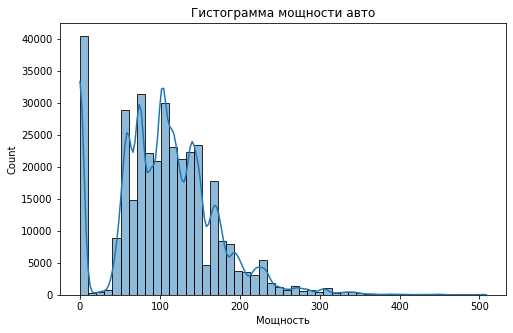

In [35]:
plt.figure(figsize=(8,5))

ax = sns.histplot(df.loc[df['power'] < 510, 'power'],  bins=50,kde=True)
ax.set_xlabel('Мощность')
ax.set_title('Гистограмма мощности авто')

1. В данных о мощности авто есть неверные значения
1. Верхняя граница мощьности принята 510, поскольку в датасете присутствуют авто с рельной мощностью двигателя 510
1. Большинство авто имеют мощьность от 50 до 200

In [36]:
data_counts = df['postal_code'].value_counts().sort_values(ascending=False)
data_counts

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
55626      1
1778       1
82493      1
86684      1
82404      1
Name: postal_code, Length: 8143, dtype: int64

Text(0.5, 1.0, 'Гистограмма числа объявлений по почтовым зонам')

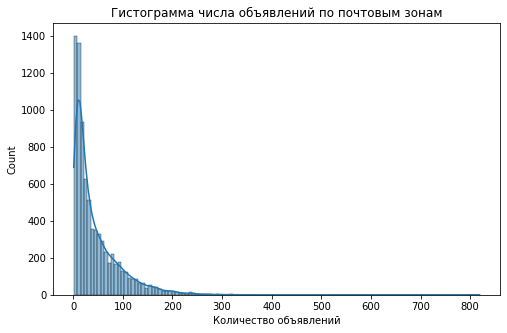

In [37]:
plt.figure(figsize=(8,5))

ax = sns.histplot(data_counts, bins=120, kde=True)
ax.set_xlabel('Количество объявлений')
ax.set_title('Гистограмма числа объявлений по почтовым зонам')

In [38]:
df.loc[df['postal_code'] < 10000, 'postal_code'] = df.loc[df['postal_code'] < 10000, 'postal_code'] * 10
df['postal_code_zone'] = df['postal_code'] // 1000

In [39]:
data_counts = df['postal_code_zone'].value_counts().sort_values(ascending=False)
data_counts

45    8676
26    8052
66    7563
65    7382
44    6819
      ... 
98     973
20     897
11     524
43     513
62     481
Name: postal_code_zone, Length: 90, dtype: int64

<bound method _AxesBase.set_xticks of <AxesSubplot:title={'center':'Колчиество объявлений по почтовым зонам'}, xlabel='Почтовая зона', ylabel='Количество объявлений'>>

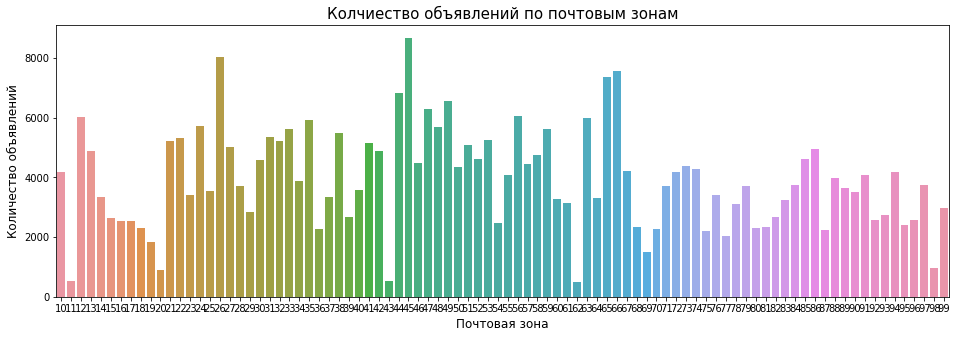

In [40]:
plt.figure(figsize=(16,5))

ax = sns.barplot(x=data_counts.index, y=data_counts.values)
ax.set_xlabel('Почтовая зона', fontsize=12)
ax.set_ylabel('Количество объявлений', fontsize=12)
ax.set_title('Колчиество объявлений по почтовым зонам', fontsize=15)

ax.set_xticks

Text(0.5, 1.0, 'Гистограмма числа объявлений по почтовым зонам')

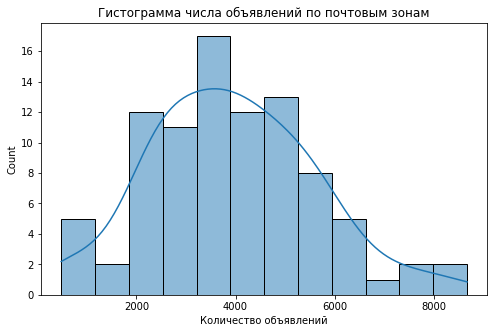

In [41]:
plt.figure(figsize=(8,5))

ax = sns.histplot(data_counts, bins=12, kde=True)
ax.set_xlabel('Количество объявлений')
ax.set_title('Гистограмма числа объявлений по почтовым зонам')

1. Почтовые коды решено сократить до первых двух цифр что означает почтовую зону, так для одной почтовой зоны включающей несоколько почтовых кодов будет больше объявлений и при обучении быдут выявленны соответствующие закономерности для каждой зоны

In [42]:
del data_counts

In [43]:
model_price = df.groupby(['brand','model']).agg(
{'price':'median'}
).reset_index().sort_values(by='price', ascending=False).reset_index(drop=True)
model_price

,brand,model,price
0,mercedes_benz,gl,18999.0
1,audi,q3,18150.0
2,mercedes_benz,glk,17850.0
3,audi,a5,16500.0
4,audi,q5,16499.0
...,...,...,...
292,ford,escort,550.0
293,rover,defender,550.0
294,daihatsu,charade,550.0
295,daihatsu,move,500.0


In [44]:
print(f"Всего {model_price.shape[0]} моделей автомобилей")
print(f"Из них {model_price[model_price['price'] < 2000].shape[0]} моделей до 2000 евро") 
print(f"{model_price[(model_price['price'] < 5000) & (model_price['price'] >= 2000)].shape[0]} моделей от 2000 до 5000 евро") 
print(f"{model_price[(model_price['price'] < 10000) & (model_price['price'] >= 5000)].shape[0]} моделей от 5000 до 10000 евро ") 
print(f"{model_price[(model_price['price'] >= 10000)].shape[0]} моделей от 10000 евро") 

Всего 297 моделей автомобилей
Из них 86 моделей до 2000 евро
103 моделей от 2000 до 5000 евро
66 моделей от 5000 до 10000 евро 
42 моделей от 10000 евро


Text(0.5, 1.0, 'Гистограмма медианной стоимости модели авто')

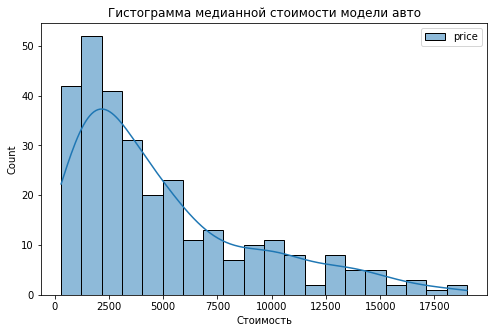

In [45]:
plt.figure(figsize=(8,5))

ax = sns.histplot(model_price, bins=20, kde=True)
ax.set_xlabel('Стоимость')
ax.set_title('Гистограмма медианной стоимости модели авто')

In [46]:
del model_price

Text(0.5, 1.0, 'Медиана стоимости в зависиомсти от пробега и ремонта')

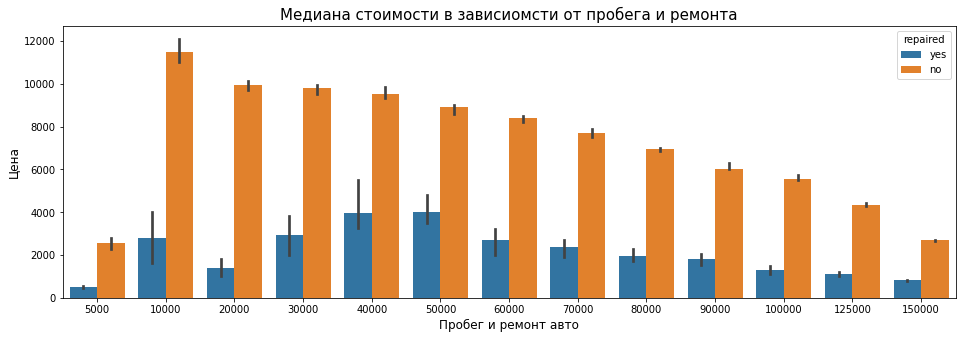

In [47]:
plt.figure(figsize=(16,5))

ax = sns.barplot(data=df, x='kilometer', y='price', hue='repaired', estimator=np.median)
ax.set_xlabel('Пробег и ремонт авто', fontsize=12)
ax.set_ylabel('Цена', fontsize=12)
ax.set_title('Медиана стоимости в зависиомсти от пробега и ремонта', fontsize=15)

1. Для машин без ремонта и пробегом 5000 видим аномальныо низкие значения - вызваны они тем, что продавци ставят 0 или другю низкую цену для привлечения внимания к объявлению, и выдачи на первых позициях при сортировке по цене объявления

In [48]:
df['model'] = df['model'].fillna(value='other')

1. Пропуски в значении модели авто заполним значение 'other'

In [49]:
%%time

for model in df['model'].unique():
    if model != 'other': 
        (df.loc[(df['model'] == model) & 
        (df['registration_year'] > 2016) | 
        (df['registration_year'] < 1961), 'registration_year']) = df.loc[df['model'] == model, 'registration_year'].median()
        
        (df.loc[(df['model'] == model) & 
        (df['power'] > 510) | 
        (df['power'] < 50), 'power']) = df.loc[df['model'] == model, 'power'].median()

    else:
        for brand in df.loc[df['model'] == 'other', 'brand'].unique():
            (df.loc[(df['brand'] == brand) & 
            (df['registration_year'] > 2016) | 
            (df['registration_year'] < 1961), 'registration_year']) = df.loc[df['brand'] == brand, 'registration_year'].median()
            
            (df.loc[(df['brand'] == brand) & 
            (df['power'] > 510) | 
            (df['power'] < 50), 'power']) = df.loc[df['brand'] == brand, 'power'].median()
                

CPU times: user 20 s, sys: 121 ms, total: 20.1 s
Wall time: 20.2 s


1. Выбросы в значениях года регистрации и мощности авто заменим медианным значением для модели авто, для тех авто марка которых имеет значение 'other' - заменим медианным значением для бренда

In [50]:
df['registration_year'].describe()

count    354369.000000
mean       2002.572415
std           6.541881
min        1961.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [51]:
df['power'].describe()

count    354369.000000
mean        118.131693
std          50.113650
min          50.000000
25%          88.000000
50%         105.000000
75%         141.000000
max         510.000000
Name: power, dtype: float64

1. Замена значения проведена успешно, выбросов нет

In [52]:
df.loc[df['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'

1. Значение 'petrol'(название бензина в Британии), заменим на 'gasoline' - название бензина в США

In [53]:
%%time

for model in df['model'].unique():
    
    if df.loc[df['model'] == model, 'fuel_type'].nunique() == 1:
        fuel_type = df.loc[df['model'] == model, 'fuel_type'].dropna().unique()[0]
        df.loc[df['model'] == model, 'fuel_type'] = df.loc[df['model'] == model, 'fuel_type'].fillna(value=fuel_type)
        
    if df.loc[df['model'] == model, 'gearbox'].nunique() == 1:
        gearbox = df.loc[df['model'] == model, 'gearbox'].dropna().unique()[0]
        df.loc[df['model'] == model, 'gearbox'] = df.loc[df['model'] == model, 'gearbox'].fillna(value=gearbox)
        
    if df.loc[df['model'] == model, 'vehicle_type'].nunique() == 1:
        vehicle_type = df.loc[df['model'] == model, 'gearbox'].dropna().unique()[0]
        df.loc[df['model'] == model, 'vehicle_type'] = df.loc[df['model'] == model, 'vehicle_type'].fillna(value=vehicle_type)

CPU times: user 15 s, sys: 105 ms, total: 15.1 s
Wall time: 15.2 s


1. Пропуски в признаках 'fuel_type', 'gearbox', 'vehicle_type' - заполним известным значением для модели авто, если для данной модели есть только одно значение

In [54]:
df['fuel_type'] = df['fuel_type'].fillna(value='other')
df['gearbox'] = df['gearbox'].fillna(value='other')
df['vehicle_type'] = df['vehicle_type'].fillna(value='other')
df['repaired'] = df['repaired'].fillna(value='other')

1. Остальные пропуски заполним значением 'other'

In [55]:
df_good = df.loc[(df['price'] >= 50)].reset_index(drop=True)

In [56]:
df_good.shape[0] / df.shape[0]

0.9649433217916917

1. Объявления с ценой меньше 50 удалим, поскольку включение таких объявлений сильно занизит предсказание стоимости авто

In [57]:
df_good = df_good.drop(['registration_month', 'date_created', 'number_of_pictures', 'date_crawled', 'postal_code', 'last_seen'], axis=1)

1. Удалим признаки которые не информативные и которые не будем использовать для обучения моделей

In [58]:
df_good

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code_zone
0,480,other,1993.0,manual,95.0,golf,150000,gasoline,volkswagen,other,70
1,18300,coupe,2011.0,manual,190.0,other,125000,gasoline,audi,yes,66
2,9800,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,other,90
3,1500,small,2001.0,manual,75.0,golf,150000,gasoline,volkswagen,no,91
4,3600,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no,60
...,...,...,...,...,...,...,...,...,...,...,...
341941,1150,bus,2000.0,manual,95.0,zafira,150000,gasoline,opel,no,26
341942,2200,other,2005.0,other,95.0,other,20000,other,sonstige_autos,other,39
341943,1199,convertible,2000.0,auto,101.0,fortwo,125000,gasoline,smart,no,26
341944,9200,bus,1996.0,manual,102.0,transporter,150000,gasoline,volkswagen,no,87


In [59]:
df_good.duplicated().sum()

24582

In [60]:
df_good = df_good.drop_duplicates()

1. Удалим дубликаты
2. Итоговый датасет для обучения и проверки моделей

<AxesSubplot:>

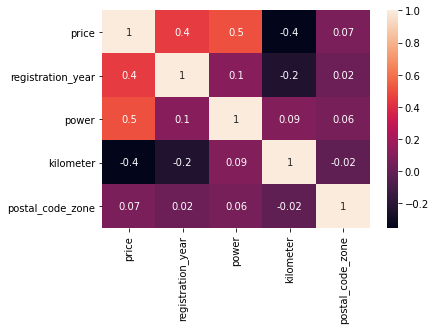

In [61]:
sns.heatmap(df_good.corr(), annot = True, fmt='.1g')

1. Хитмап корреляции значений признаков

## Обучение моделей

In [62]:
features = df_good.drop('price', axis=1)
target = df_good['price']

In [63]:
target = df_good['price']
features = df_good.drop('price', axis=1)
features_train, features_tv, target_train, target_tv = train_test_split(features, target, 
                                                                        test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_tv, target_tv, 
                                                                        test_size=0.5, random_state=12345)
print('features_train', features_train.shape)
print('target_train', target_train.shape)
print('features_valid', features_valid.shape)
print('target_valid', target_valid.shape)
print('features_test', features_test.shape)
print('target_test', target_test.shape)

features_train (190418, 10)
target_train (190418,)
features_valid (63473, 10)
target_valid (63473,)
features_test (63473, 10)
target_test (63473,)


In [64]:
features_train['less_year'] = np.where(features_train['registration_year'] == features_train['registration_year'].max(), 1, 0)
features_valid['less_year'] = np.where(features_valid['registration_year'] == features_valid['registration_year'].max(), 1, 0)
features_test['less_year'] = np.where(features_test['registration_year'] == features_test['registration_year'].max(), 1, 0)

1. Добавим признак означающий что машина зарегистрирована в текущем году

In [65]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'postal_code_zone', 'less_year']
numeric_features = ['registration_year', 'power', 'kilometer']

1. Создадим списки численных и категориальных признаков

In [66]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_features])

StandardScaler()

In [67]:
def scaler_features(features):
    scal_features = pd.DataFrame(scaler.transform(features[numeric_features]), 
                                 columns= numeric_features, index=features.index)
    features = features.drop(numeric_features, axis=1)
    return pd.concat([scal_features, features], axis=1)

In [68]:
features_train_scaled = scaler_features(features_train)
features_valid_scaled = scaler_features(features_valid)
features_test_scaled = scaler_features(features_test)

**Исследование на модели KNeighborsRegressor**

In [69]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

In [70]:
encoder.fit(features_train[cat_features])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [71]:
def enc_features(features):
    enc_features = pd.DataFrame(encoder.transform(features[cat_features]).toarray(), 
                                columns=encoder.get_feature_names_out(), index=features.index)
    features = features.drop(cat_features, axis=1)
    return pd.concat([enc_features, features], axis=1)

In [72]:
features_train_transform = enc_features(features_train_scaled)
features_valid_transform = enc_features(features_valid_scaled)

In [73]:
model = KNeighborsRegressor()

In [106]:
%%time


model.fit(features_train_transform, target_train)

CPU times: user 761 ms, sys: 484 ms, total: 1.25 s
Wall time: 1.25 s


KNeighborsRegressor()

In [107]:
%%time


predicted_valid = model.predict(features_valid_transform)

CPU times: user 12min 52s, sys: 3.63 s, total: 12min 56s
Wall time: 1min 12s


In [108]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [109]:
print('RMSE: %.3f ' % (rmse))

RMSE: 2095.469 


In [110]:
model = KNeighborsRegressor(n_neighbors=3)

In [111]:
%%time


model.fit(features_train_transform, target_train)

CPU times: user 1.44 s, sys: 369 ms, total: 1.81 s
Wall time: 511 ms


KNeighborsRegressor(n_neighbors=3)

In [112]:
%%time


predicted_valid = model.predict(features_valid_transform)

CPU times: user 12min 47s, sys: 3.83 s, total: 12min 51s
Wall time: 1min 10s


In [113]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [114]:
print('RMSE: %.3f ' % (rmse))

RMSE: 2189.883 


**Исследование на моедли CatBoostRegressor**

In [115]:
model = CatBoostRegressor(cat_features=cat_features, random_state=42, learning_rate=0.5, iterations=300)

1. CatBoostRegressor по умолчанию функция потерь RMSE

In [116]:
%%time


model.fit(features_train_scaled, target_train)

0:	learn: 3231.4644731	total: 137ms	remaining: 41s
1:	learn: 2634.7476216	total: 196ms	remaining: 29.3s
2:	learn: 2359.2956669	total: 254ms	remaining: 25.1s
3:	learn: 2206.4851429	total: 301ms	remaining: 22.3s
4:	learn: 2124.1227266	total: 357ms	remaining: 21s
5:	learn: 2063.3013427	total: 418ms	remaining: 20.5s
6:	learn: 2035.4405263	total: 468ms	remaining: 19.6s
7:	learn: 2009.5371856	total: 511ms	remaining: 18.6s
8:	learn: 1995.5448982	total: 557ms	remaining: 18s
9:	learn: 1976.6921818	total: 621ms	remaining: 18s
10:	learn: 1963.2722837	total: 663ms	remaining: 17.4s
11:	learn: 1947.4515634	total: 705ms	remaining: 16.9s
12:	learn: 1936.4800618	total: 764ms	remaining: 16.9s
13:	learn: 1923.5335109	total: 818ms	remaining: 16.7s
14:	learn: 1915.0696067	total: 871ms	remaining: 16.5s
15:	learn: 1906.4147718	total: 923ms	remaining: 16.4s
16:	learn: 1897.3796651	total: 975ms	remaining: 16.2s
17:	learn: 1885.4247099	total: 1.02s	remaining: 16s
18:	learn: 1877.7000647	total: 1.06s	remaining: 

In [117]:
%%time


predicted_valid = model.predict(features_valid_scaled)

CPU times: user 586 ms, sys: 21 ms, total: 607 ms
Wall time: 150 ms


In [118]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [119]:
print('RMSE: %.3f ' % (rmse))

RMSE: 1724.135 


In [120]:
model = CatBoostRegressor(cat_features=cat_features, random_state=42, learning_rate=0.9, iterations=100)

In [121]:
%%time


model.fit(features_train_scaled, target_train)

0:	learn: 2722.2831440	total: 25.3ms	remaining: 2.5s
1:	learn: 2367.8910227	total: 53.6ms	remaining: 2.62s
2:	learn: 2241.0250133	total: 72.7ms	remaining: 2.35s
3:	learn: 2148.3506507	total: 90.8ms	remaining: 2.18s
4:	learn: 2090.9763136	total: 108ms	remaining: 2.06s
5:	learn: 2053.9986649	total: 125ms	remaining: 1.96s
6:	learn: 2028.0397289	total: 144ms	remaining: 1.92s
7:	learn: 1983.2955175	total: 165ms	remaining: 1.9s
8:	learn: 1961.1755304	total: 183ms	remaining: 1.85s
9:	learn: 1947.0258087	total: 203ms	remaining: 1.82s
10:	learn: 1929.4830155	total: 224ms	remaining: 1.81s
11:	learn: 1916.4696802	total: 245ms	remaining: 1.8s
12:	learn: 1909.8001509	total: 270ms	remaining: 1.81s
13:	learn: 1901.4037282	total: 293ms	remaining: 1.8s
14:	learn: 1894.1522685	total: 315ms	remaining: 1.78s
15:	learn: 1882.7239801	total: 334ms	remaining: 1.75s
16:	learn: 1876.0817855	total: 357ms	remaining: 1.74s
17:	learn: 1863.5714072	total: 379ms	remaining: 1.72s
18:	learn: 1856.3379483	total: 399ms	r

In [122]:
%%time


predicted_valid = model.predict(features_valid_scaled)

CPU times: user 140 ms, sys: 5.58 ms, total: 145 ms
Wall time: 87.9 ms


In [124]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [125]:
print('RMSE: %.3f ' % (rmse))

RMSE: 1780.286 


1. Время обучения и предсказания модели меньше 1 минуты
1. RMSE 1695.06

**Модель LGBMRegressor**

In [126]:
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_features])

OrdinalEncoder()

1. Для обучения LGBMRegressor преобразуем категориальные признаки в целочисленные с помощью OrdinalEncoder

In [128]:
model = LGBMRegressor(random_state=42, learning_rate=0.5, num_iterations=300)

In [129]:
%%time


model.fit(features_train_transform, target_train)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 7.96 s, sys: 2.13 s, total: 10.1 s
Wall time: 1.96 s


LGBMRegressor(learning_rate=0.5, num_iterations=300, random_state=42)

In [130]:
%%time


predicted_valid = model.predict(features_valid_transform)

CPU times: user 1.78 s, sys: 191 ms, total: 1.98 s
Wall time: 396 ms


In [131]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [132]:
print('RMSE: %.3f ' % (rmse))

RMSE: 1704.652 


In [133]:
model = LGBMRegressor(random_state=42, learning_rate=0.9, num_iterations=500)

In [134]:
%%time


model.fit(features_train_transform, target_train)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


CPU times: user 10.3 s, sys: 3.57 s, total: 13.9 s
Wall time: 2.09 s


LGBMRegressor(learning_rate=0.9, num_iterations=500, random_state=42)

In [135]:
%%time


predicted_valid = model.predict(features_valid_transform)

CPU times: user 3.19 s, sys: 1.32 s, total: 4.51 s
Wall time: 476 ms


In [136]:
rmse = mean_squared_error(target_valid, predicted_valid, squared=False)

In [137]:
print('RMSE: %.3f ' % (rmse))

RMSE: 1795.007 


1. Время обучения и предсказания модели меньше 1 минуты
1. RMSE 1704.06

## Анализ моделей

1. KNeighborsRegressor работала медленно из-за того что модель запоминает все признаки на train и потому что мы сильно увеличили признаковое пространство преобразованием категориальных признаков OHE, но модель на кросс-валидации выдает результат RMSE 2062.359 что удовлетворяет требованию поставленной задачи
1. Результаты времени и значения ошибки у моделей CatBoostRegressor и LGBMRegressor примерно равные RMSE 1700 
1. Поскольку полученный результат выше требуемого по заданию, для сокращения времени и ресурсов модем понизить увеличить learning rate и понизить число итераций
1. Для обучения и предсказания выберем модель CatBoostRegressor

In [144]:
features_train_scaled_full = pd.concat([features_train_scaled, features_valid_scaled])
target_train_full = pd.concat([target_train, target_valid])

In [157]:
model = CatBoostRegressor(cat_features=cat_features, random_state=42, learning_rate=1, iterations=10)

In [158]:
%%time

model.fit(features_train_scaled_full, target_train_full)

0:	learn: 2706.7159682	total: 31.5ms	remaining: 284ms
1:	learn: 2410.7549821	total: 64.4ms	remaining: 258ms
2:	learn: 2286.8581678	total: 86.9ms	remaining: 203ms
3:	learn: 2195.6274068	total: 109ms	remaining: 164ms
4:	learn: 2143.0348180	total: 131ms	remaining: 131ms
5:	learn: 2095.5695529	total: 158ms	remaining: 105ms
6:	learn: 2051.0727667	total: 181ms	remaining: 77.6ms
7:	learn: 2015.6213674	total: 203ms	remaining: 50.8ms
8:	learn: 1992.1068438	total: 226ms	remaining: 25.1ms
9:	learn: 1973.6941320	total: 251ms	remaining: 0us
CPU times: user 3.09 s, sys: 124 ms, total: 3.22 s
Wall time: 596 ms


In [159]:
%%time

predicted_test = model.predict(features_test_scaled)

CPU times: user 126 ms, sys: 7.15 ms, total: 133 ms
Wall time: 82.7 ms


In [160]:
rmse = mean_squared_error(target_test, predicted_test, squared=False)
print('RMSE: %.2f' % (rmse))

RMSE: 1972.71


1. Полученный результат на тестовой выборке удовлетворяет требованиям задачи

**Вывод**

1. Задача:

    1. В данной работе была построена модель и получены предсказания стоимости авто в объявлении на основании и данные о технических характеристиках, комплектации и ценах других автомобилей.
    1. Основными критериями для модели были: качество предсказания, время обучения модели, время предсказания модели


2. Данные:
    1. Для выполнения задачи были предоставленны данные объявлений о продажи авто
    1. В данных содержат 354369 объектов с 15 признаками
    1. Некоторые признаки (дата размещения, дата изьятия объявления, месяц размещения и др) для предсказания стоимости не понадобились и были исключены, но использовались на этапе предобработки, так с помощью даты размещения объявления была определена верхняя граница признака дата регистрации авто в которой содержались ошибочные значения
    1. Так же ошибочные значения (выбросы) содержались во всех числовых признаках, кроме километража пробега авто,
    1. Были проанализированы зависимости между признками и реальные данные и на их основе неверные значения были заменены для сохранения данных
    1. Аномальные значения были обнаружены и в целевом признак стоимости авто - были объявления с 0 или ценой до 50 евро в т.ч. на авто с пробегом до 5000 км без ремонта. Был сделан вывод что таким образом продавцы привлекают внимание и трафик на свои объявления и цена таких объявлений не соответствует реальной. Эти объявления были удалены
    1. После предобработки данных был создан итоговый датасет из которого были удалены повторы объявлений
    1. В признаки был добавлен признка означающий что машина зарегестрирована в текущем году
    
    
3. Обучение моделей и предсказания:
    1. Основными критериями были время обучения, время предсказания, точность результата
    1. Для выполенения задания было выбрано три модели: KNeighborsRegressor, CatBoostRegressor и LGBMRegressor
    1. Численные признаки были отмаштабированы с помощью StandartScaler, категориальные признаки преобразованы в численные или переданны модели с указанием на категорий
    1. Самой быстрое обучение показада модель KNeighborsRegressor поскольку она не обучается, а запоминает обучающую выброку, но время предсказания оказалось большое, больше 2 минут, RMSE = 2000 предсказания  удовлетворяющая условию.
    1. Модели CatBoostRegressor и LGBMRegressor показали почти одинаковые результаты RMSE, времени обучения и предсказания. RMSE предсказаний = 1700, время меньше минуты.
    1. Итоговой моделью для проверки на тестовой выборке была выбрана модель CatBoostRegressor. Поскольку полученный RMSE был выше требуемого, для сокращения времени обучения и предсказания гиперпараметры learning rate и число итераций были изменены.
    1. Для обучения конечной модели тестовая и валидационная выбори были объеденины, для увеличения объема обучающих данных
    1. Результатом работы удалось достигунить значения меньше требуемого RMSE при этом с сократив время обучения и предсказания
